In [130]:
import numpy
import random


class state:
    def __init__(self, ball_x, ball_y, velocity_x, velocity_y, paddle_y):
        self.b_x = ball_x
        self.b_y = ball_y
        self.v_x = velocity_x
        self.v_y = velocity_y
        self.p_y = paddle_y
        self.p_x = 1
        self.p_h = 0.2
        self.running = 1


    def actions(self, input):
        if input == 0:
            #print("up")
            self.p_y -= 0.04
            if self.p_y <= 0:
                self.p_y = 0
        elif input == 2:
            #print("down")
            self.p_y += 0.04
            if self.p_y >= 0.8:
                self.p_y = 0.8


    def terminate(self):
        self.running = 0
        #print("end")


    def updatestate(self, score):
        self.b_x += self.v_x
        self.b_y += self.v_y

        if self.b_x >= 1:
            if self.p_y <= self.b_y <= self.p_y + 0.2:
                score += 1
                self.b_x = 2 * self.p_x - self.b_x
                U = random.uniform(-0.015, 0.015)
                V = random.uniform(-0.03, 0.03)
                self.v_x = -self.v_x + U
                self.v_y += V
                if abs(self.v_x < 0.03):
                    if self.v_x > 0:
                        self.v_x = 0.03
                    else:
                        self.v_x = -0.03
                if self.v_x > 1:
                    self.v_x = 1
                if self.v_y > 1:
                    self.v_y = 1
            else:
                score -= 1
                self.terminate()
        else:
            if self.b_x < 0:
                self.b_x = -self.b_x
                self.v_x = -self.v_x
            if self.b_y < 0:
                self.b_y = -self.b_y
                self.v_y = -self.v_y
            elif self.b_y > 1:
                self.b_y = 2 - self.b_y
                self.v_y = -self.v_y

        return score


#grid = numpy.zeros((12, 12))
#initial_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - 0.2 / 2)

In [131]:
import numpy as np

class cache:
    def __init__(self, in_A, in_W, in_b):
        self.A = in_A
        self.W = in_W
        self.b = in_b

In [132]:
import numpy as np
from random import shuffle

acc_count = 0
conf_mat = np.zeros((3, 3))
epoch_count = 0

def read_data(input_file_dir):
    '''
    INPUT : input_file_dir: The input file to be read
    OUTPUT : The data arranged in a 3d numpy array - (image, rows, cols)
    '''
    
    data_list = []
    examples_count = 0
    with open(input_file_dir, 'r+') as file:
        for line in file:
            for numstr in line.split(" "):
                if numstr:
                    digits = float(numstr)
                    data_list += [digits]
    state = np.zeros((10000,5))
    decision = np.zeros(10000)
    for i in np.arange(10000):
        state[i, :] = data_list[i * 6: i * 6 + 5]
        decision[i] = int(data_list[i*6 + 5])
    return state, decision

def affine_fwd(A, W, b):
    #print("affine\n", A, "\n", W, "\n")
    n_sample = A.shape[0]
    n_unit = W.shape[1]
    #n_unit = 1
    b_mtx = np.tile(b, [n_sample,1])
    affine_out = np.dot(A, W) + b_mtx
    cache_obj = cache(A, W, b)
    #print("aff_fwd\n", affine_out)
    return affine_out, cache_obj

def affine_bwd(dZ, cache):
    dA = np.dot(dZ, cache.W.transpose())
    dW = np.dot(cache.A.transpose(), dZ)
    db = np.sum(dZ, axis=0)
    return dA, dW, db

def relu_fwd(Z):
    n_sample = Z.shape[0]
    n_unit = Z.shape[1]
    A = np.zeros((n_sample, n_unit))
    A = np.maximum(Z, 0)
    #print("relu\n", A)          
    return A, Z

def relu_bwd(dA, cache):
    n_sample = dA.shape[0]
    n_unit = dA.shape[1]
    dZ = np.zeros((n_sample, n_unit))
    dZ = cache
    dZ[dZ <=0] = 0
    dZ[dZ > 0] = 1
    dZ *= dA
    #print(dZ)
    return dZ

def cross_entropy(F, y):
    n_sample = F.shape[0]
    expF = np.exp(F)
    fsum = 0;
    dF = np.zeros((n_sample, 3))
    #print(F)
    for i in np.arange(n_sample):
        fsum += F[i][int(y[i])]
        temp_log = 0
        for j in np.arange(3):
            temp_log = np.sum(expF[i,:])
            idnt = 0
            if j == y[i]:
                idnt = 1
            dF[i][j] = -1 / n_sample * (idnt - expF[i][j]/temp_log)
        temp_log = np.log(temp_log)
        fsum -= temp_log
    loss = -1/n_sample * fsum
    #print("cross_ent\n")
    return loss, dF
    
def train_nn(X, W1, W2, W3, W4, b1, b2, b3, b4, y, l_rate):
    inst_num = X.shape[0]
    global acc_count
    global conf_mat
    global epoch_count
    Z1, acache1 = affine_fwd(X, W1, b1)
    A1, rcache1 = relu_fwd(Z1)
    #print("affine1\n",A1)
    Z2, acache2 = affine_fwd(A1, W2, b2)
    A2, rcache2 = relu_fwd(Z2)
    #print("affine2\n",A2)
    Z3, acache3 = affine_fwd(A2, W3, b3)
    A3, rcache3 = relu_fwd(Z3)
    #print("affine3\n",A3)
    F, acache4 = affine_fwd(A3, W4, b4)
    #print("affine4\n", F)
    
    loss, dF = cross_entropy(F, y)
    
    decision = F.argmax(1)
    #if epoch_count > 99:
    #    print(decision)
    for i in np.arange(inst_num):
        pred = int(decision[i])
        act = int(y[i])
        conf_mat[act][pred] += 1
        if pred == act:
            #print("correct")
            acc_count += 1
    
    dA3, dW4, db4 = affine_bwd(dF, acache4)
    dZ3 = relu_bwd(dA3, rcache3)
    
    dA2, dW3, db3 = affine_bwd(dZ3, acache3)
    dZ2 = relu_bwd(dA2, rcache2)
    
    dA1, dW2, db2 = affine_bwd(dZ2, acache2)
    dZ1 = relu_bwd(dA1, rcache1)
    
    dX, dW1, db1 = affine_bwd(dZ1, acache1)
    
    W1 = W1 - l_rate * dW1
    W2 = W2 - l_rate * dW2
    W3 = W3 - l_rate * dW3
    W4 = W4 - l_rate * dW4
    
    b1 = b1 - l_rate * db1
    b2 = b2 - l_rate * db2
    b3 = b3 - l_rate * db3
    b4 = b4 - l_rate * db4
    
    return loss, W1, W2, W3, W4, b1, b2, b3, b4

def test_nn(X, W1, W2, W3, W4, b1, b2, b3, b4):
    #print(X)
    Z1, acache1 = affine_fwd(X, W1, b1)
    A1, rcache1 = relu_fwd(Z1)
    
    Z2, acache2 = affine_fwd(A1, W2, b2)
    A2, rcache2 = relu_fwd(Z2)
    
    Z3, acache3 = affine_fwd(A2, W3, b3)
    A3, rcache3 = relu_fwd(Z3)
    
    F, acache4 = affine_fwd(A3, W4, b4)
    decision = F.argmax(1)
    #print(F)
    
    #print(decision)
    return decision
    
def init_params(unit_num):
    W1 = ( np.random.rand(5, unit_num) - 0.5 )
    W2 = ( np.random.rand(unit_num, unit_num) - 0.5 )
    W3 = ( np.random.rand(unit_num, unit_num) - 0.5 )
    W4 = ( np.random.rand(unit_num, 3) - 0.5 )
    
    b1 = np.zeros(unit_num)
    b2 = np.zeros(unit_num)
    b3 = np.zeros(unit_num)
    b4 = np.zeros(3)
    
    return W1, W2, W3, W4, b1, b2, b3, b4

def minibatch_gd(X,  y, l_rate, batch_size, unit_num, n_epoch):
    global conf_mat
    global acc_count
    global epoch_count
    epoch_count = 0
    conf_mat = np.zeros((3,3))
    acc_count = 0
    loss_vec = np.zeros(n_epoch)
    acc_vec = np.zeros(n_epoch)
    W1, W2, W3, W4, b1, b2, b3, b4 = init_params(unit_num)
    curr_batch = np.zeros((batch_size, 5))
    curr_targ = np.zeros(batch_size)
    for round in np.arange(n_epoch):
        epoch_count += 1
        tot_loss = 0
        ind_list  = [i for i in range(10000)]
        ln_rate = l_rate
        if round > n_epoch / 2:
            ln_rate = l_rate / ( round - (n_epoch / 2) + 1 )
        #print(ind_list)
        np.random.shuffle(ind_list)
        #print(ind_list)
        X_shuffled = X[ind_list, :]
        y_shuffled = y[ind_list]
        for batch in np.arange(10000/batch_size):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            curr_batch = X_shuffled[batch_start:batch_end, :]
            curr_targ = y_shuffled[batch_start:batch_end]
            #print(curr_batch)
            #print(curr_batch.shape, curr_targ.shape)
            loss, W1, W2, W3, W4, b1, b2, b3, b4 = train_nn(curr_batch, W1, W2, W3, W4, b1, b2, b3, b4, curr_targ, ln_rate)
            tot_loss += loss
        accuracy = acc_count / (10000 * (round + 1))
        loss_vec[round] = tot_loss
        acc_vec[round] = accuracy
        if round == n_epoch - 1:
            print(tot_loss, accuracy,"\n")
    
    return W1, W2, W3, W4, b1, b2, b3, b4, loss_vec, acc_vec, conf_mat


In [93]:
F = [[-0.5451707440533535,-0.4912870364592141, -0.8839416793522488],
[-0.13116674888375845,-0.37640823601179485,0.392686977630919],
[-0.2444963214150382,-0.6407926448807304, -0.9506425432173375],
[-0.8655007370735028,0.3587855469971346, -0.09260631088790938],
[0.0731584222174444,0.7933425860806842, 0.9806778947934087], 
[-0.5662060312030521, 0.3261564062002016, -0.4733552465256987], 
[-0.9586980010685426, 0.5167573076722829, -0.3599656983550643],
[-0.23307221165620406, 0.17663422710721144, 0.6620969104723808],
[0.25796368718229745, 0.7453013108947906, -0.45291593036872846],
[0.5960936678251274, -0.6287281113880956, 0.9055833139438891]]

y = [0, 0, 0, 1, 0, 2, 2, 2, 0, 0]
F = np.asarray(F)

loss, dF = cross_entropy(F, y)
print(loss, dF)

1.10179173821 [[-0.06387293  0.03812713  0.0257458 ]
 [-0.07119017  0.02254414  0.04864603]
 [-0.0538394   0.03105719  0.02278222]
 [ 0.01522588 -0.04820555  0.03297967]
 [-0.08192655  0.03713753  0.04478903]
 [ 0.02203523  0.05378556 -0.07582079]
 [ 0.01390272  0.06079696 -0.07469968]
 [ 0.0201852   0.03040649 -0.05059169]
 [-0.06794038  0.0521923   0.01574807]
 [-0.06235704  0.01105988  0.05129717]]


[  5.04928100e-01   5.15399200e-01   4.49400000e-04   3.75000000e-05
   4.98532000e-01] [ 0.28852226  0.27917053  0.04633403  0.03042119  0.21827562]
[[-0.01708048 -0.05516055  0.6377731   0.32748549 -0.45141093]
 [ 0.08689763 -0.01934015  0.6377731   0.32748549 -0.26815638]
 [ 0.19087574  0.01648025  0.6377731   0.32748549 -0.08490183]
 ..., 
 [-0.25623014 -1.18350314 -0.82983063  1.87246097  0.28160727]
 [-0.38793575 -0.97932686 -0.82983063  1.87246097  0.46486182]
 [-0.51617542 -0.77515058 -0.82983063  1.87246097  0.28160727]]
8.90975546249 0.933114 



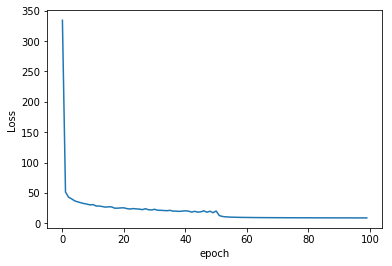

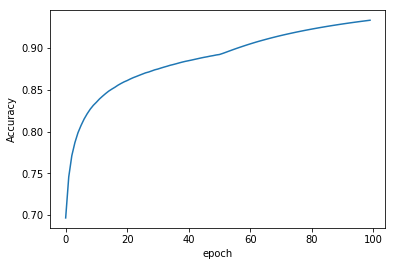

[[ 0.92407618  0.02420216  0.05172166]
 [ 0.03585574  0.92495092  0.03919334]
 [ 0.032644    0.02284756  0.94450844]]


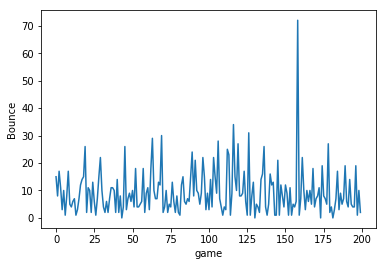

9.415


In [133]:
#a_in = np.random.uniform(-1,1,(10,5))
#w_in = np.random.uniform(0,1,(5,6))
#b_in = np.random.uniform(0,1,6)
#y_in = [0, 1, 2, 1, 0]
#F_in = np.random.uniform(-1,1,(5, 3))
#aff_test, cache_test = cross_entropy(F_in, y_in)
#print(cache_test, "\n", aff_test)

#from pong import state
import matplotlib.pyplot as plt

#w1, w2, w3, w4, b1, b2, b3, b4 = init_params(50, 32)
exp_state, exp_decision = read_data("expert_policy.txt")
mean = np.mean(exp_state, axis = 0)
sdv = np.std(exp_state, axis = 0)
print(mean, sdv)
#exp_state -= np.tile(mean, (5,1)).T
#exp_state /= np.tile(sdv,(5,1)).T
exp_state = exp_state - mean
exp_state = exp_state / sdv
print(exp_state)

#test_state = exp_state[0:50, :]
#test_dec = exp_decision[0:50]

w1, w2, w3, w4, b1, b2, b3, b4, loss, acc, conf = minibatch_gd(exp_state, exp_decision, 0.05, 100, 256, 100)
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()
conf_sum = np.sum(conf, axis = 1)
for i in np.arange(3):
    for j in np.arange(3):
        conf[i][j] /= conf_sum[i]
print(conf)

scores = np.zeros(200)
for num_games in np.arange(200):
    initial_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - 0.2 / 2)
    score = 0
    while initial_state.running == 1:
        game_state = [initial_state.b_x, initial_state.b_y, initial_state.v_x, initial_state.v_y, initial_state.p_y]
        #print(game_state)
        game_state -= mean
        game_state /= sdv
        game_state = np.asarray(game_state)
        in_state = np.zeros((1,5))
        in_state[0,:] = game_state
        decision = test_nn(in_state, w1, w2, w3, w4, b1, b2, b3, b4)
        initial_state.actions(decision[0])
        score = initial_state.updatestate(score)
    scores[num_games] = score
    #print(score)

plt.plot(scores)
plt.ylabel('Bounce')
plt.xlabel('game')
plt.show()
print(np.mean(scores))
